In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import scipy
import matplotlib.pyplot as plt

import sys, os

In [2]:
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
from lib.cgamma import c_multi_gamma_sf, c_multi_gamma_sf_v, c_multi_gamma_prob, c_multi_gamma_prob_v 
from lib.plotting import adjust_plot_1d
from lib.simdata_i3 import I3SimHandler
from lib.geo import center_track_pos_and_time_based_on_data
from lib.network import get_network_eval_v_fn
from lib.experimental_methods import remove_early_pulses
from likelihood_spe import get_neg_c_triple_gamma_llh
from dom_track_eval import get_eval_network_doms_and_track_altrho as get_eval_network_doms_and_track

In [3]:
from lib.geo import cherenkov_cylinder_coordinates_w_rho_v
from lib.geo import get_xyz_from_zenith_azimuth

In [4]:
dtype = jnp.float32
event_index = 1

# Get network and eval logic.
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network', dtype=dtype)
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=dtype)

In [5]:
# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandler(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

print("n_doms", len(event_data))

muon energy: 2.0 TeV
n_doms 97


In [6]:
# Make MCTruth seed.
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

print("original seed vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, 
                                                                                  track_pos, 
                                                                                  track_time, 
                                                                                  track_src)
print("shifted seed vertex:", centered_track_pos)

original seed vertex: [ -57.58777311  104.94960582 -459.58699572]
shifted seed vertex: [  79.52905078  241.90677754 -291.78433739]


In [7]:
def remove_early_pulses(eval_network_doms_and_track, data, track_pos, track_dir, track_time):
    crit = -10.0
    _, _, _, geo_times = eval_network_doms_and_track(data[:,:3], track_pos, track_dir)
    delay_times = data[:, 3] - geo_times - track_time
    idx = delay_times > crit
    filtered_data = data[idx]
    return filtered_data

In [8]:
fitting_event_data = jnp.array(event_data[['x', 'y', 'z', 'time', 'charge']].to_numpy())
print(fitting_event_data.shape)

fitting_event_data = remove_early_pulses(eval_network_doms_and_track,
                                         fitting_event_data,
                                         centered_track_pos,
                                         track_src,
                                         centered_track_time)
print(fitting_event_data.shape)

(97, 5)
(97, 5)


In [9]:
def get_neg_c_triple_gamma_llh_mpe(eval_network_doms_and_track_fn):
    """
    here would be a smart docstring
    """

    @jax.jit
    def neg_c_triple_gamma_llh(track_direction,
                               track_vertex,
                               track_time,
                               event_data):
        
        # Constant parameters.
        sigma = 3.0 # width of gaussian convolution
        X_safe = 20.0 # when to stop evaluating negative time residuals in units of sigma
        delta = 0.1 # how to combine the three regions that combine approximate and exact evaluation of hyp1f1 (required for convolutions). Small values are faster. Large values are more accurate.


        dom_pos = event_data[:, :3]
        first_hit_times = event_data[:, 3]
        charges = event_data[:, 4]
        n_photons = jnp.round(charges + 0.5)
        
        logits, av, bv, geo_time = eval_network_doms_and_track_fn(dom_pos, track_vertex, track_direction)

        mix_probs = jax.nn.softmax(logits)
        #mix_probs = jax.nn.softmax(logits[:, 1:])
        #av = av[:, 1:2]
        #bv = bv[:, 1:2]
        delay_time = first_hit_times - (geo_time + track_time)

        # Floor on negative time residuals.
        # Effectively a floor on the pdf.
        # Todo: think about noise.
        safe_delay_time = jnp.where(delay_time > -X_safe * sigma, delay_time, -X_safe * sigma)

        probs = c_multi_gamma_prob_v(safe_delay_time, 
                                     mix_probs,
                                     av,
                                     bv,
                                     sigma,
                                     delta)

        sfs = c_multi_gamma_sf_v(safe_delay_time, mix_probs, av, bv, sigma)

        mpe_log_probs = jnp.log(n_photons) + jnp.log(probs) + (n_photons-1.0) * jnp.log(sfs)
        return -2.0 * jnp.sum(mpe_log_probs)


    return neg_c_triple_gamma_llh

In [10]:
neg_llh_mpe = get_neg_c_triple_gamma_llh_mpe(eval_network_doms_and_track)
neg_llh_mpe_grad = jax.grad(neg_llh_mpe)

for index in range(len(fitting_event_data)):
    llh_val = neg_llh_mpe(track_src, centered_track_pos, centered_track_time, fitting_event_data[index: index+1])
    llh_grad = neg_llh_mpe_grad(track_src, centered_track_pos, centered_track_time, fitting_event_data[index: index+1])
    if np.any(np.isnan(llh_grad)):
        print("DOM", index)
        print(llh_val, llh_grad)

In [11]:
def get_dom_info(track_direction, track_vertex, track_time, event_data):
        
        # Constant parameters.
        sigma = 3.0 # width of gaussian convolution
        X_safe = 20.0 # when to stop evaluating negative time residuals in units of sigma
        delta = 0.1 # how to combine the three regions that combine approximate and exact evaluation of hyp1f1 (required for convolutions). Small values are faster. Large values are more accurate.


        dom_pos = event_data[:, :3]
        first_hit_times = event_data[:, 3]
        charges = event_data[:, 4]
        n_photons = jnp.round(charges + 0.5)
        print("n_hits:", n_photons)

        track_dir_xyz = get_xyz_from_zenith_azimuth(track_direction)
        geo_time, closest_approach_dist, closest_approach_z, closest_approach_rho = \
            cherenkov_cylinder_coordinates_w_rho_v(dom_pos, track_vertex, track_dir_xyz)

        print("dist, z, rho=", closest_approach_dist, closest_approach_z, closest_approach_rho)
        
        logits, av, bv, geo_time = eval_network_doms_and_track(dom_pos, track_vertex, track_direction)
        print("gamma_a:", av)
        print("gamma_b:", bv)
        mix_probs = jax.nn.softmax(logits)
        delay_time = first_hit_times - (geo_time + track_time)

        # Floor on negative time residuals.
        # Effectively a floor on the pdf.
        # Todo: think about noise.
        safe_delay_time = jnp.where(delay_time > -X_safe * sigma, delay_time, -X_safe * sigma)
        print("delay time:", safe_delay_time)

        probs = c_multi_gamma_prob_v(safe_delay_time, 
                                     mix_probs,
                                     av,
                                     bv,
                                     sigma,
                                     delta)

        print("pdf:", probs)
        sfs = c_multi_gamma_sf_v(safe_delay_time, mix_probs, av, bv, sigma)

        print("sf:", sfs)
        return mix_probs, av, bv, safe_delay_time

In [12]:
index = 53
mix_probs, gamma_a, gamma_b, delay_time = get_dom_info(track_src, centered_track_pos, centered_track_time, fitting_event_data[index: index+1])

n_hits: [2.]
dist, z, rho= [17.66502672] [-361.78880666] [-0.19604577]
gamma_a: [[1.82426572 3.7310195  1.00109863]]
gamma_b: [[0.04011903 0.33388111 0.00209452]]
delay time: [6.93197039]
pdf: [0.03525814]
sf: [0.84308835]


In [13]:
print(track_src)

[2.28442419 3.9264083 ]


In [14]:
print(mix_probs)

[[0.37396463 0.50085439 0.12518099]]


In [15]:
def finite_difference_grad(track_direction, track_pos, track_time, fitting_event_data):
    eps = 1.e-7
    
    track_direction1 = track_direction + jnp.array([eps, 0.0])
    track_direction2 = track_direction - jnp.array([eps, 0.0])
    fval1 = neg_llh_mpe(track_direction1, track_pos, track_time, fitting_event_data)
    fval2 = neg_llh_mpe(track_direction2, track_pos, track_time, fitting_event_data)
    grad1 = (fval1 - fval2)/(2*eps)

    track_direction1 = track_direction + jnp.array([0.0, eps])
    track_direction2 = track_direction - jnp.array([0.0, eps])
    fval1 = neg_llh_mpe(track_direction1, track_pos, track_time, fitting_event_data)
    fval2 = neg_llh_mpe(track_direction2, track_pos, track_time, fitting_event_data)
    grad2 = (fval1 - fval2)/(2*eps)
    
    return jnp.array([grad1, grad2])

In [16]:
index = 53
print(finite_difference_grad(track_src,
                             centered_track_pos,
                             centered_track_time,
                             fitting_event_data[index:index+1]))

[44.45664939  3.55451565]


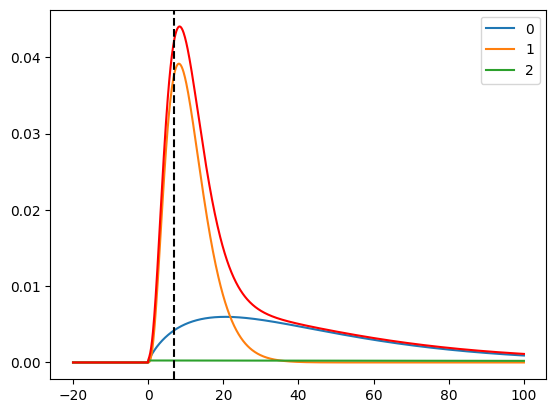

In [17]:
from scipy.stats import gamma
xvals = np.linspace(-20, 100, 1000)

fig, ax = plt.subplots()
mixed_pdf = np.zeros_like(xvals)
for i in range(3):
    probs = mix_probs[0, i] * gamma.pdf(xvals, gamma_a[0, i], scale=1/gamma_b[0, i])
    plt.plot(xvals, probs, label=f"{i}")
    mixed_pdf += probs

plt.plot(xvals, mixed_pdf, color='red')
plt.axvline(delay_time, color='black', linestyle='dashed')
plt.legend()
plt.show()

In [18]:
print(delay_time)

[6.93197039]


In [19]:
print(mix_probs)

[[0.37396463 0.50085439 0.12518099]]


In [20]:
sigma=3.0
alpha=2.5
sqrt2sigma2 = jnp.sqrt(2.0*sigma**2)
ymin = delay_time - alpha*sqrt2sigma2 # start of numeric integration
ymin = jnp.where(ymin >= 0.0, ymin, 0.0)
ymax = delay_time + alpha*sqrt2sigma2 # end of numeric integration
ymax = jnp.where(ymax >= 0.0, ymax, 0.0)
print(ymin, ymax)

[0.] [17.53857211]
